# Feature Engineering

In their raw form, features are often a poor fit for Machine Learning usage. Often times, you have to scale them down or manufacture new features based on original features in order to attain a useful data set.

Here, I give a brief and basic example of such a task.

1. Load the data into DataFrame
2. Scale the data using StandardScaler
3. Create some new features
4. Look to see if any features have discriminating power
5. Check that new features are time-invariant

## 1. Load the data into a DataFrame

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("white")
sns.set_context("paper", font_scale=1.4)

In [2]:
data_df = pd.read_csv('raw-data.csv', index_col='eventID')
data_df.head()

,AfterInhMATRIX5,PrescaleMATRIX5,RawMATRIX4,RawTriggers,label
eventID,,,,,
430001,27094,12,1598521,10759045,2
430002,34901,14,1670878,11813291,3
430003,36317,15,1675869,12002554,3
430004,34088,14,1637602,11564482,3
430005,27489,12,1587623,10627391,4


## 2. Scale the data using StandardScaler

In [6]:
# Very standard and useful tool for scaling features
from sklearn.preprocessing import StandardScaler

scaled_df = data_df.copy()
scaled_df[scaled_df.columns[:-1]].astype(float)
scaled_df[scaled_df.columns[:-1]] = \
    scaled_df[scaled_df.columns[:-1]].apply(lambda x: StandardScaler().fit_transform(x))

### Note the new distribution

StandardScaler scales everything down such that:

* the mean is zero
* the standard deviation is unity

In [11]:
scaled_df.describe().ix[['mean', 'std']]

,AfterInhMATRIX5,PrescaleMATRIX5,RawMATRIX4,RawTriggers,label
mean,-1.732807e-15,-4.399711e-15,-1.885897e-15,-4.881057e-16,2.644401
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.866411


### To get a good visual, plot it

See that everything is just scaled down and shifted. The distribution is intact.

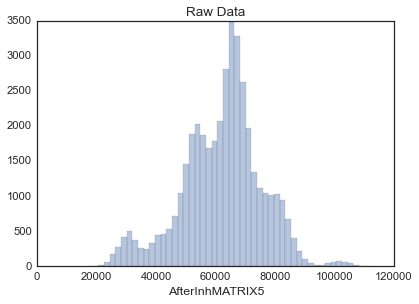

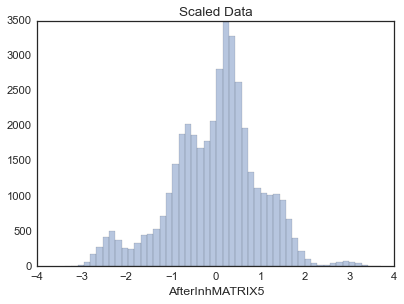

In [10]:
sns.distplot(data_df.AfterInhMATRIX5, kde=False)
plt.title("Raw Data")
plt.show()
sns.distplot(scaled_df.AfterInhMATRIX5, kde=False)
plt.title("Scaled Data")
plt.show()

### Rename for ease of use

Now that we've robbed them of their real values, let's strip them of their real names.

In [14]:
scaled_df.columns = ['f1', 'f2', 'f3', 'f4', 'label']
scaled_df.head()

,f1,f2,f3,f4,label
eventID,,,,,
430001,-2.607248,-2.444682,-1.476104,-1.815155,2
430002,-2.027589,-2.091403,-1.331993,-0.384589,3
430003,-1.922453,-1.914763,-1.322052,-0.127767,3
430004,-2.087953,-2.091403,-1.398268,-0.722212,3
430005,-2.577919,-2.444682,-1.497809,-1.993804,4


## 3. Create some new features

1. The difference between two or more features
2. One feature scaled by another

In [ ]:
data_df['f2-f1'] = data_df['f2'] - data_df['f1']
data_df['f3-f1'] = data_df['f3'] - data_df['f1']
data_df['f4-f1'] = data_df['f4'] - data_df['f1']
data_df['f3-f2'] = data_df['f3'] - data_df['f2']
data_df['f4-f2'] = data_df['f4'] - data_df['f2']
data_df['f4-f3'] = data_df['f4'] - data_df['f3']
data_df.head()

In [ ]:
sns.violinplot(x='label', y='f2-f1', data=data_df)
plt.show()
sns.violinplot(x='label', y='f3-f1', data=data_df)
plt.show()
sns.violinplot(x='label', y='f4-f1', data=data_df)
plt.show()
sns.violinplot(x='label', y='f3-f2', data=data_df)
plt.show()
sns.violinplot(x='label', y='f4-f2', data=data_df)
plt.show()
sns.violinplot(x='label', y='f4-f3', data=data_df)
plt.show()